In [ ]:
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime
import joblib
import yaml
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

from makers.model import build_model
from makers.utils import prepare, get_metrics

In [74]:
DATA_PATH = "_input/data/book-COINBASE-BTC-USD.csv"
CONFIG_PATH = "_input/config.yml"
OUTDIR = '_output'

In [ ]:
# load config
config = yaml.safe_load(open(CONFIG_PATH, 'r'))

# specify paths
model_name = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(OUTDIR, 'models', model_name)
model_path = os.path.join(model_dir, 'model.h5')
metrics_path = os.path.join(model_dir, 'metrics.txt')
config_path = os.path.join(model_dir, 'config.yml')

os.makedirs(model_dir, exist_ok=True)

# Resampling

There are three labels: buy, hold and sell. The classes are imbalanced as there are many more hold samples compared to the other ones. In order to equalize the classes, one needs to either undersample the majority class, or oversample the minority classes.

In [39]:
def undersample(df, scaler, depth, window_size):
    
    slice_step = len(df) // np.sum(df['signal'] != 0) // 2 if np.sum(df['signal'] != 0) > 0 else 1
    idx = df[df['signal'] != 0].index.to_list() + df[df['signal'] == 0][::slice_step].index.to_list()
    idxnum = [df.index.get_loc(x) for x in idx if df.index.get_loc(x) > window_size]

    # get samples
    X1 = prepare(df, idxnum, depth, window_size)

    # rescale
    n_samples = X1.shape[0]
    X1[:] = scaler.fit_transform(X1[:, :, :, 0].reshape((n_samples, -1))).reshape(
        (n_samples, window_size, depth * 4, 1))

    # encode labels
    y = df['signal'].iloc[idxnum].to_numpy()
    enc = OneHotEncoder(sparse=False)
    y = enc.fit_transform(y.reshape(-1, 1))

    # otherwise some classes are missing
    assert y.shape[1] == 3, "Some classes are missing."

    # NB: shuffle=True has look-ahead bias!
    X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, shuffle=True)

    return X1_train, X1_test, y_train, y_test


In [40]:
def oversample(df, scaler, depth, window_size):
    
    slice_step = 10
    idx = df[df['signal'] != 0].index.to_list() + df[df['signal'] == 0][::slice_step].index.to_list()
    idxnum = [df.index.get_loc(x) for x in idx if df.index.get_loc(x) > window_size]

    # get samples
    X1 = prepare(df, idxnum, depth, window_size)

    # rescale
    n_samples = X1.shape[0]
    X1[:] = scaler.fit_transform(X1[:, :, :, 0].reshape((n_samples, -1))).reshape(
        (n_samples, window_size, depth * 4, 1))

    # encode labels
    y = df['signal'].iloc[idxnum].to_numpy()
    enc = OneHotEncoder(sparse=False)
    y = enc.fit_transform(y.reshape(-1, 1))

    # otherwise some classes are missing
    assert y.shape[1] == 3, "Some classes are missing."

    ros = RandomOverSampler(random_state=42)

    X1, y = ros.fit_resample(X1.reshape((n_samples, -1)), y)

    n_samples = X1.shape[0]
    X1 = X1.reshape((n_samples, window_size, 4 * depth, 1))

    # NB: shuffle=True has look-ahead bias!
    X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, shuffle=True)

    return X1_train, X1_test, y_train, y_test

# Training

The data is sampled at 50ms. Each timestep has a UTC timestamp and 40 features: bid price and volume and ask price and volume, 10 levels deep.

Labels are quantized as follows:
* if the maximum ask price over the next 5 seconds - current ask price > threshold, label is +1
* if the current bid price - minimum bid price over the next 5 seconds > threshold, label is -1
* 0, otherwise

So thus it's a classification, and not a regression task (which is more common AFAIK), but we could build a regression model too.

In [44]:
# load dataset
print(f'Loading dataset {DATA_PATH}.')
df = pd.read_csv(DATA_PATH, index_col='timestamp', parse_dates=True).sort_index()

# dedupe
df = df[~df.index.duplicated(keep='first')]

Loading dataset _input/book-COINBASE-BTC-USD.csv.


In [ ]:
# we use the fact that data is sampled at 50ms
min_periods = config['model']['prediction_horizon'] * 1000 / 50

print(f'Calculating labels.')

# calculate indicators (use [::-1] to have rolling windows for successive, not trailing timesteps)
df['p+'] = df['ap0'][::-1].rolling(td, min_periods=min_periods).max()[::-1] - df['ap0']
df['p-'] = df['bp0'] - df['bp0'][::-1].rolling(td, min_periods=min_periods).min()[::-1]

# remove na
df = df[~df.isna().any(axis=1)]

# calculate labels
df['signal'] = (df['p+'] > config['model']['threshold']).astype(int) - (df['p-'] > config['model']['threshold']).astype(int)


Classes are imbalanced, resampling to equalize them.

(array([ 15187.,      0.,      0.,      0.,      0., 666145.,      0.,
             0.,      0.,  17356.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

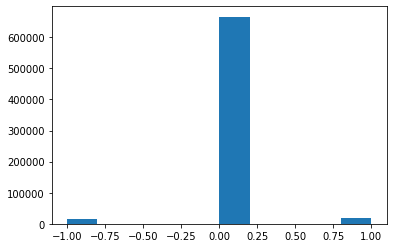

In [60]:
plt.hist(df['signal'])

In [ ]:
# resample and split

scaler = StandardScaler()

assert config['model']['resampling'] in 'undersample', 'oversample'

if config['model']['resampling'] == 'undersample':
    X1_train, X1_test, y_train, y_test = undersample(df, scaler, config['model']['depth'], config['model']['window_size'])
elif config['model']['resampling'] == 'oversample':
    X1_train, X1_test, y_train, y_test = oversample(df, scaler, config['model']['depth'], config['model']['window_size'])
    
plt.hist(np.argmax(y_train, axis=1))


In [65]:
# dump scaler into file
scaler_path = os.path.join(model_dir, 'scaler1.h5')
joblib.dump(scaler, scaler_path)

['_output/models/20220214_155018/scaler1.h5']

In [70]:
# build and train model

model = build_model(window_size=config['model']['window_size'], depth=config['model']['depth'])
cp_callback = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', save_weights_only=True,
                              save_best_only=True)

history = model.fit(X1_train, y_train,
                    epochs=config['training']['n_epochs'],
                    batch_size=config['training']['batch_size'],
                    validation_split=0.15, callbacks=[cp_callback],
                    verbose=2)

Epoch 1/50
1062/1062 - 7s - loss: 1.0265 - accuracy: 0.4717 - val_loss: 1.5475 - val_accuracy: 0.3554
Epoch 2/50
1062/1062 - 6s - loss: 0.9204 - accuracy: 0.5649 - val_loss: 1.0602 - val_accuracy: 0.4810
Epoch 3/50
1062/1062 - 6s - loss: 0.8080 - accuracy: 0.6393 - val_loss: 1.5799 - val_accuracy: 0.4152
Epoch 4/50
1062/1062 - 6s - loss: 0.7218 - accuracy: 0.6862 - val_loss: 1.1044 - val_accuracy: 0.5619
Epoch 5/50
1062/1062 - 5s - loss: 0.6629 - accuracy: 0.7158 - val_loss: 0.9589 - val_accuracy: 0.6294
Epoch 6/50
1062/1062 - 6s - loss: 0.6146 - accuracy: 0.7415 - val_loss: 1.0686 - val_accuracy: 0.5885
Epoch 7/50
1062/1062 - 6s - loss: 0.5793 - accuracy: 0.7599 - val_loss: 0.7728 - val_accuracy: 0.6753
Epoch 8/50
1062/1062 - 5s - loss: 0.5491 - accuracy: 0.7737 - val_loss: 0.6207 - val_accuracy: 0.7141
Epoch 9/50
1062/1062 - 6s - loss: 0.5275 - accuracy: 0.7840 - val_loss: 0.6210 - val_accuracy: 0.7420
Epoch 10/50
1062/1062 - 5s - loss: 0.5085 - accuracy: 0.7941 - val_loss: 1.0056 - 

In [72]:
# save history
history_path = os.path.join(model_dir, 'history.csv')
history_df = pd.DataFrame(history.history)
history_df.to_csv(history_path, index=False)

In [73]:
# load and evaluate the best model

model.load_weights(model_path)

loss, accuracy = model.evaluate(X1_test, y_test, verbose=0)

y_pred_num = np.argmax(model.predict(X1_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)

metrics = get_metrics(y_test_num, y_pred_num)

output = (
    f"{'loss':20}{loss:7.4f}\n"
    f"{'accuracy':20}{accuracy:7.4f}\n\n"
    f"{metrics}"
)

print(output)

f = open(metrics_path, 'w')
f.write(output)
f.close()
print(f"Metrics written to {metrics_path}.")

yaml.dump(config, open(config_path, 'w'))
print(f"Config copied to {config_path}.")


loss                 0.3471
accuracy             0.8669

r2                     0.79
precision            0.9060  0.8276  0.8640
recall               0.9128  0.7675  0.9198
fscore               0.9094  0.7964  0.8910
support               13298   13273   13398

confusion matrix    
  12139    1076      83
   1230   10187    1856
     29    1046   12323

Metrics written to _output/models/20220214_155018/metrics.txt.
Config copied to _output/models/20220214_155018/config.yml.
